# 4. Utilization Prediction

In this section we predict the absolute Utilization (number of cars per hour) as well as the percentage Utilization (percentage of possible charging minutes occupied)

## 4.1 Data preperation

In [436]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [437]:
# read in dataset
charging_set_complete = pd.read_csv("data/cleaned_charging_set.csv")

In [438]:
# get information about the dataset
charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62362 entries, 0 to 62361
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  62362 non-null  object 
 1   connectionTime                      62362 non-null  object 
 2   disconnectTime                      62362 non-null  object 
 3   doneChargingTime                    62362 non-null  object 
 4   kWhDelivered                        62362 non-null  float64
 5   sessionID                           62362 non-null  object 
 6   siteID                              62362 non-null  int64  
 7   spaceID                             62362 non-null  object 
 8   stationID                           62362 non-null  object 
 9   userID                              62362 non-null  float64
 10  WhPerMile                           62362 non-null  float64
 11  kWhRequested                        62362

In [439]:
# read in dataset
weather_set = pd.read_csv("data/cleaned_weather_set.csv")

In [440]:
# get info about dataset
weather_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
 9   temperature_difference   29218 non-null  float64
 10  date_year                29244 non-null  int64  
 11  date_month               29244 non-null  int64  
 12  date_day                 29244 non-null  int64  
 13  time                     29244 non-null  object 
 14  mostly                

In [441]:
print(weather_set["timestamp"].max(),charging_set_complete["connectionTime"].max())

2021-01-01 07:53:00 2021-09-14 05:43:39+00:00


In [442]:
print(weather_set["timestamp"].min(),charging_set_complete["connectionTime"].min())

2018-01-01 08:53:00 2018-04-25 11:08:04+00:00


As we can see the datasets have different time frames, whcih we have to keep in mind for merging later. Unfortunetly this means some data will be lost. 

In [443]:
# seperate data into site 1 and site 2
charging_set_site1 = charging_set_complete[charging_set_complete["siteID"] == 1]
charging_set_site2 = charging_set_complete[charging_set_complete["siteID"] == 2]

In [444]:
# drop duplicates and look at dataset
df_no_duplicates = charging_set_site1.drop_duplicates()
charging_set_site1.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,connect_weekday,disconnect_weekday,chargingDone_disconnect_difference
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020.0,1.0,2.0,20:51:54,3.0,6.039167,4.378056,3,3,1.661111
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020.0,1.0,2.0,23:31:50,3.0,9.025278,6.687500,3,3,2.337778
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020.0,1.0,2.0,14:56:35,3.0,10.713056,2.641944,3,4,8.071111
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,...,2020.0,1.0,2.0,15:04:58,3.0,2.644722,1.313056,3,3,1.331667
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,2020.0,1.0,2.0,22:24:01,3.0,8.144167,4.291389,3,3,3.852778


In [445]:
# check space amount of each parking site 
amount_spaces1 = charging_set_site1["spaceID"].nunique()
amount_spaces2 = charging_set_site2["spaceID"].nunique()
print(amount_spaces1,amount_spaces2)

52 54


Let's create a dataframe that contains an entry for every hour in between the first and last charging event. This will becime usefull for the prediction later, as the task is to specifically predict hourly utiliaztion.

In [446]:
# Convert to datetime
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])
# sort acsending
charging_set_site1 = charging_set_site1.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site1['connectionTime'].min().floor('H')
max_time = charging_set_site1['disconnectTime'].max().ceil('H')

# create df for every hour 
hours_df = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df.head()


/var/folders/2p/xvrd9yr13yb4vz2jsw9pykbh0000gn/T/ipykernel_39393/3682515635.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
/var/folders/2p/xvrd9yr13yb4vz2jsw9pykbh0000gn/T/ipykernel_39393/3682515635.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])


,hour
0,2018-10-08 13:00:00+00:00
1,2018-10-08 14:00:00+00:00
2,2018-10-08 15:00:00+00:00
3,2018-10-08 16:00:00+00:00
4,2018-10-08 17:00:00+00:00


Implement the same code for site 2

In [447]:
# Combine date and time columns into single datetime columns

charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])
# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)
# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('H')
max_time = charging_set_site2['disconnectTime'].max().ceil('H')
# create df
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='H')})
hours_df2.head()


/var/folders/2p/xvrd9yr13yb4vz2jsw9pykbh0000gn/T/ipykernel_39393/3618000106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
/var/folders/2p/xvrd9yr13yb4vz2jsw9pykbh0000gn/T/ipykernel_39393/3618000106.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])


,hour
0,2018-04-25 11:00:00+00:00
1,2018-04-25 12:00:00+00:00
2,2018-04-25 13:00:00+00:00
3,2018-04-25 14:00:00+00:00
4,2018-04-25 15:00:00+00:00


We can see that there are different timeframes of data available for both sites. 

In [448]:
# check for duplicates to make sure df creation was succesful 
print(hours_df.duplicated().sum(), hours_df2.duplicated().sum())

0 0


In [449]:
# check for duplicates in charging sets
print(charging_set_site1.duplicated().sum(), charging_set_site2.duplicated().sum())


1412 0


In [450]:
# drop duplicates we foundin site 1
charging_set_site1 = charging_set_site1.drop_duplicates()
charging_set_site1.duplicated().sum()

0

Now we want to create our target variables that we want to predict later. For this we create 2 values: 
- connectedCars: the number of active charging sessions for each other
- utilization: the actual number of minutes that was charged for each hour 

The utiliaztion column effectivly sums up the active charging minutes for each hour and divides that by the maximum number of minutes that could be charged. In case of sitze 1 for example that would mean 60x52 = 3120 are the max charging miinutes for this site per hour. If we divide the minutes of active sessions by this value, we get the precise percentage of the charging site utilization.

**Calculation for site 1:**

In [451]:


# Number of spaces (total available spaces site 1)
total_spaces = 52

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # Filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
    ]
    
    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[0]
)

# Compute connectedCars column
hours_df['connectedCars'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[1]
)

# Display results
hours_df.head()


,hour,utilization,connectedCars
0,2018-10-08 13:00:00+00:00,0.038301,4
1,2018-10-08 14:00:00+00:00,0.215855,19
2,2018-10-08 15:00:00+00:00,0.365385,19
3,2018-10-08 16:00:00+00:00,0.365385,19
4,2018-10-08 17:00:00+00:00,0.365385,19


**Calculation for site 2**

In [452]:
# Number of spaces (total available spaces site 1)
total_spaces = 54

# Function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # Filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
    ]
    
    # Calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # Utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# Compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[0]
)

# Compute connectedCars column
hours_df2['connectedCars'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[1]
)

# Display results
hours_df2.head()


,hour,utilization,connectedCars
0,2018-04-25 11:00:00+00:00,0.016029,1
1,2018-04-25 12:00:00+00:00,0.018519,1
2,2018-04-25 13:00:00+00:00,0.015175,3
3,2018-04-25 14:00:00+00:00,0.059378,7
4,2018-04-25 15:00:00+00:00,0.253596,22


In [453]:
hours_df.describe()

,utilization,connectedCars
count,25731.000000,25731.000000
mean,0.162239,9.673740
std,0.298516,16.875325
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.019231,1.000000
75%,0.147487,10.000000
max,1.000000,61.000000


In [454]:
hours_df2.describe()

,utilization,connectedCars
count,29705.000000,29705.000000
mean,0.107012,6.776435
std,0.177842,10.784268
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.024552,2.000000
75%,0.120628,8.000000
max,0.932865,56.000000



# 1. Convert `hour` and `timestamp` to datetime format for merging
hours_df['hour'] = pd.to_datetime(hours_df['hour'])
weather_set['timestamp'] = pd.to_datetime(weather_set['timestamp'])

# 2. Merge the datasets on the timestamp columns
merged_data2 = pd.merge(hours_df, weather_set, left_on='hour', right_on='timestamp', how='inner')

**Merge Target Variable and Weather Dataset**

In [455]:
# transform column to the same format
hours_df["hour"] = hours_df["hour"].dt.tz_localize(None)
hours_df2["hour"] = hours_df2["hour"].dt.tz_localize(None)

# Convert the "timestamp" column in the weather data to datetime
weather_set["timestamp"] = pd.to_datetime(weather_set["timestamp"])

# Round the weather data timestamps to the nearest hour
weather_set["timestamp"] = weather_set["timestamp"].dt.floor("H")

# Merge the datasets based on the "timestamp" column
merged_data_site1 = pd.merge(hours_df, weather_set, left_on="hour", right_on="timestamp", how="left")
merged_data_site2 = pd.merge(hours_df2, weather_set, left_on="hour", right_on="timestamp", how="left")
# Drop the redundant "timestamp" column from the weather data after merging
merged_data_site1 = merged_data_site1.drop(columns=["timestamp"])
merged_data_site2 = merged_data_site2.drop(columns=["timestamp"])

In [456]:
merged_data_site1.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-10-08 13:00:00,0.038301,4,Burbank,13.0,34.0,Fair,982.53,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-10-08 14:00:00,0.215855,19,Burbank,14.0,28.0,Mostly Cloudy,982.86,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-10-08 14:00:00,0.215855,19,Burbank,14.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-10-08 14:00:00,0.215855,19,Burbank,15.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018-10-08 15:00:00,0.365385,19,Burbank,17.0,30.0,Partly Cloudy,983.19,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [457]:
merged_data_site2.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [458]:
# check dataset range
print(merged_data_site1["hour"].max(),merged_data_site1["hour"].max())

2021-09-14 15:00:00 2021-09-14 15:00:00


In [459]:
# check NaN values 
print(merged_data_site1.isna().sum(),merged_data_site2.isna().sum())

hour                          0
utilization                   0
connectedCars                 0
city                       6225
temperature                6249
cloud_cover                6244
cloud_cover_description    6244
pressure                   6225
windspeed                  6289
precipitation              6225
felt_temperature           6250
temperature_difference     6250
date_year                  6225
date_month                 6225
date_day                   6225
time                       6225
mostly                     6225
heavy                      6225
fog                        6225
windy                      6225
blowing_dust               6225
fair                       6225
haze                       6225
partly                     6225
rain                       6225
light_rain_thunder         6225
light                      6225
t-storm                    6225
thunder                    6225
thunder_in_vicinity        6225
cloudy                     6225
smoke   

In [460]:
# drop NaN values
merged_data_site1 = merged_data_site1.dropna()
merged_data_site2 = merged_data_site2.dropna()

In [461]:
# check if NaN values were dropped
print(merged_data_site1.isna().sum(),merged_data_site2.isna().sum())

hour                       0
utilization                0
connectedCars              0
city                       0
temperature                0
cloud_cover                0
cloud_cover_description    0
pressure                   0
windspeed                  0
precipitation              0
felt_temperature           0
temperature_difference     0
date_year                  0
date_month                 0
date_day                   0
time                       0
mostly                     0
heavy                      0
fog                        0
windy                      0
blowing_dust               0
fair                       0
haze                       0
partly                     0
rain                       0
light_rain_thunder         0
light                      0
t-storm                    0
thunder                    0
thunder_in_vicinity        0
cloudy                     0
smoke                      0
dtype: int64 hour                       0
utilization                0
c

In [462]:
# check max date now
print(merged_data_site1["hour"].max(),merged_data_site2["hour"].max())

2021-01-01 07:00:00 2021-01-01 07:00:00


In [463]:
# chec for duplicates
print(merged_data_site1.duplicated().sum(),merged_data_site2.duplicated().sum())

0 0


In [464]:
merged_data_site1.describe()

,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,date_year,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,21761.000000,...,21761.000000,21761.000000,21761.000000,21761.0,21761.000000,21761.000000,21761.000000,21761.0,21761.000000,21761.000000
mean,0.181084,10.749001,17.519691,29.996094,986.936628,8.365608,0.067853,17.344883,0.202472,2019.335049,...,0.022379,0.085796,0.048527,0.0,0.033868,0.000919,0.000735,0.0,0.312715,0.015027
std,0.330176,18.588465,6.493010,5.577375,3.696341,6.761500,0.511736,6.339552,0.605198,0.657122,...,0.147918,0.280069,0.214882,0.0,0.180893,0.030303,0.027106,0.0,0.463610,0.121662
min,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,13.000000,26.000000,984.500000,0.000000,0.000000,13.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.017297,1.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.140860,10.000000,21.000000,34.000000,989.110000,13.000000,0.000000,21.000000,0.000000,2020.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,1.000000,61.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,2021.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [465]:
merged_data_site2.describe()

,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,date_year,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,...,26073.000000,26073.000000,26073.000000,26073.0,26073.000000,26073.000000,26073.000000,26073.0,26073.000000,26073.000000
mean,0.126242,7.978599,18.180762,30.169601,986.635407,8.590764,0.056776,18.023051,0.204886,2019.114256,...,0.020443,0.085951,0.041115,0.0,0.028880,0.000767,0.000729,0.0,0.319909,0.012542
std,0.190089,11.516048,6.524775,5.324878,3.569460,6.625866,0.468224,6.382549,0.598130,0.778731,...,0.141511,0.280297,0.198561,0.0,0.167474,0.027686,0.026986,0.0,0.466450,0.111287
min,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,13.000000,26.000000,984.170000,6.000000,0.000000,13.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.037037,2.000000,17.000000,33.000000,986.150000,7.000000,0.000000,17.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.154923,11.000000,22.000000,34.000000,988.780000,13.000000,0.000000,22.000000,0.000000,2020.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,0.932865,56.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,2021.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [466]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
]
print(len(filtered_data),len(filtered_data2))

2281 2281


In [467]:
zero_connected_cars_count = filtered_data[filtered_data['connectedCars'] == 0].shape[0]
zero_connected_cars_count2 = filtered_data2[filtered_data2['connectedCars'] == 0].shape[0]
print(zero_connected_cars_count,zero_connected_cars_count2)

2258 2261


As we saw in the descriptive analysis (Section 2) there is a gap of data between august 2020 and Oktober 2020. This will most likely have a negativ impact on our model performance because as seen above those values are almost all 0. Therefore we are dropping them.

In [468]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

In [469]:
merged_data_site2.describe()

,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,date_year,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,...,23792.000000,23792.000000,23792.000000,23792.0,23792.000000,23792.000000,23792.000000,23792.0,23792.000000,23792.000000
mean,0.138330,8.742476,17.639879,30.111256,986.818043,8.710575,0.062219,17.502522,0.180061,2019.029338,...,0.018746,0.092888,0.044931,0.0,0.031523,0.000841,0.000799,0.0,0.338979,0.003362
std,0.194750,11.775518,6.295080,5.380985,3.612164,6.675769,0.489811,6.203124,0.559766,0.762976,...,0.135629,0.290282,0.207157,0.0,0.174731,0.028982,0.028249,0.0,0.473373,0.057890
min,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,13.000000,26.000000,984.500000,6.000000,0.000000,13.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.051433,3.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.176731,13.000000,22.000000,34.000000,989.110000,13.000000,0.000000,22.000000,0.000000,2020.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,0.932865,56.000000,45.000000,47.000000,999.650000,57.000000,18.540000,41.000000,5.000000,2021.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [470]:
merged_data_site1.describe()

,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,date_year,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,19480.000000,...,19480.000000,19480.000000,19480.000000,19480.0,19480.000000,19480.000000,19480.000000,19480.0,19480.000000,19480.000000
mean,0.202134,11.998563,16.781674,29.904517,987.194964,8.485575,0.075798,16.629723,0.171869,2019.257187,...,0.020534,0.094251,0.054055,0.0,0.037680,0.001027,0.000821,0.0,0.335164,0.004107
std,0.342806,19.260589,6.115738,5.668388,3.738242,6.841371,0.540312,6.022547,0.559173,0.651563,...,0.141821,0.292184,0.226133,0.0,0.190425,0.032026,0.028648,0.0,0.472060,0.063954
min,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,12.000000,26.000000,984.500000,6.000000,0.000000,12.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.019231,1.000000,16.000000,33.000000,986.810000,7.000000,0.000000,16.000000,0.000000,2019.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.202997,14.000000,21.000000,34.000000,989.770000,13.000000,0.000000,21.000000,0.000000,2020.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,1.000000,61.000000,38.000000,47.000000,999.650000,57.000000,18.540000,37.000000,5.000000,2021.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


### Feature Engineering

**Create new features for site 1**

In [471]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# Add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())
 
# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# Resulting DataFrame
merged_data_site1.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-10-08 13:00:00,0.038301,4,Burbank,13.0,34.0,Fair,982.53,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,3,0,2,13
1,2018-10-08 14:00:00,0.215855,19,Burbank,14.0,28.0,Mostly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
2,2018-10-08 14:00:00,0.215855,19,Burbank,14.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
3,2018-10-08 14:00:00,0.215855,19,Burbank,15.0,30.0,Partly Cloudy,982.86,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,14
4,2018-10-08 15:00:00,0.365385,19,Burbank,17.0,30.0,Partly Cloudy,983.19,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0,3,0,2,15


**Create new Features for site 2**

In [472]:
# create season column and weekend/weekday column and covvid column
merged_data_site2["hour"] = pd.to_datetime(merged_data_site2["hour"])
# Add covid column
merged_data_site2["covid"] = merged_data_site2["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site2["weekday"] = merged_data_site2["hour"].apply(lambda x: x.weekday())
 
# Function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# Apply the season mapping
merged_data_site2["Season"] = merged_data_site2["date_month"].apply(get_season)

# Add weekday/weekend column 
merged_data_site2["Weekday/Weekend"] = merged_data_site2["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# Mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site2["Season"] = merged_data_site2["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# Apply the function to create a new column
merged_data_site2["time_of_day"] = merged_data_site2["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site2["hour_of_day"] = merged_data_site2["hour"].dt.hour
# Resulting DataFrame
merged_data_site2.head()


,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,1,11
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13


#### Feature Selection for site 1

In [473]:

# Compute correlation matrix
correlation_matrix = merged_data_site1.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)


Correlation with connectedCars:
connectedCars             1.000000
utilization               0.990689
hour_of_day               0.427674
time_of_day               0.372780
felt_temperature          0.230305
temperature               0.228838
windspeed                 0.147869
haze                      0.063535
temperature_difference    0.036012
precipitation             0.032907
t-storm                   0.032543
cloud_cover               0.025493
partly                    0.023888
heavy                     0.022714
thunder                   0.017866
Season                    0.017391
rain                      0.012854
windy                     0.011307
light                     0.008637
fair                     -0.000409
pressure                 -0.001097
mostly                   -0.008293
fog                      -0.009978
date_day                 -0.011986
cloudy                   -0.023204
smoke                    -0.026335
date_month               -0.048439
date_year              

We pick out feature that have a higher influence than 5 percent. Therefore we end with: time_of_day,windspeed,temperature,felt_temperature,smoke,,season,date_month,weekday,weekday/weekend and covid. We do not include date_year to avoid data leakage

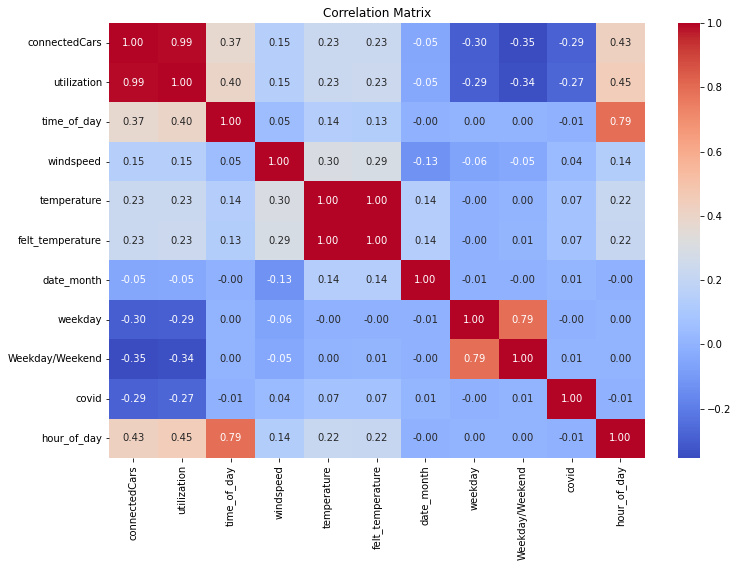

In [474]:
# compute correlation and display correlation for newly selected features
predictionDF_site1 = merged_data_site1[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site1.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Feature Selection for site 2

In [475]:

# Compute correlation matrix
correlation_matrix = merged_data_site2.corr()


# Correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

Correlation with connectedCars:
connectedCars             1.000000
utilization               0.989421
felt_temperature          0.402579
temperature               0.399290
hour_of_day               0.296392
time_of_day               0.228746
windspeed                 0.224150
Season                    0.149610
temperature_difference    0.118144
cloud_cover               0.083780
fair                      0.052138
date_month                0.040261
partly                    0.036633
thunder                   0.024121
t-storm                   0.018863
haze                      0.015340
smoke                     0.013047
windy                    -0.006117
heavy                    -0.006692
precipitation            -0.008013
date_day                 -0.008442
light                    -0.023000
mostly                   -0.024356
rain                     -0.030976
fog                      -0.033500
cloudy                   -0.042431
pressure                 -0.104824
weekday                

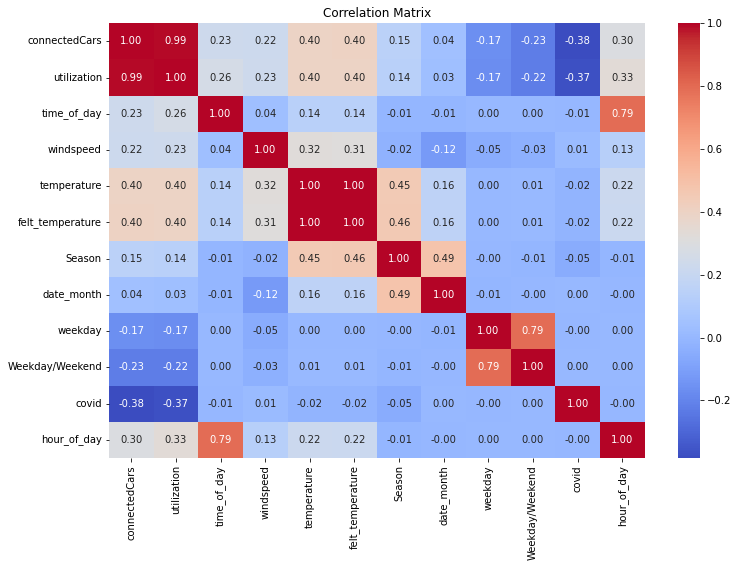

In [476]:
# compute correlation and display correlation for newly selected features
predictionDF_site2 = merged_data_site2[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","Season","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site2.corr()
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### ConnectedCars predicting Neural Network site 1

In [477]:

X = predictionDF_site1.copy()
X = predictionDF_site1.drop(["connectedCars","utilization","temperature","time_of_day"],axis = 1)
y = predictionDF_site1[["connectedCars"]]

In [478]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19480 entries, 0 to 21940
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   connectedCars  19480 non-null  int64
dtypes: int64(1)
memory usage: 304.4 KB


In [479]:

X.head()

,windspeed,felt_temperature,date_month,weekday,Weekday/Weekend,covid,hour_of_day
0,0.0,13.0,10.0,0,0,0,13
1,0.0,14.0,10.0,0,0,0,14
2,0.0,14.0,10.0,0,0,0,14
3,0.0,15.0,10.0,0,0,0,14
4,0.0,17.0,10.0,0,0,0,15


In [480]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19480 entries, 0 to 21940
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   windspeed         19480 non-null  float64
 1   felt_temperature  19480 non-null  float64
 2   date_month        19480 non-null  float64
 3   weekday           19480 non-null  int64  
 4   Weekday/Weekend   19480 non-null  int64  
 5   covid             19480 non-null  int64  
 6   hour_of_day       19480 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


In [481]:
X.isna().sum()


windspeed           0
felt_temperature    0
date_month          0
weekday             0
Weekday/Weekend     0
covid               0
hour_of_day         0
dtype: int64

In [482]:
X = X.dropna()
y = y.dropna()

In [483]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [484]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

/Users/mariustheobald/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [485]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [486]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 307.1087 - mae: 10.1490 - val_loss: 99.7802 - val_mae: 5.9729
Epoch 2/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 84.4691 - mae: 5.1632 - val_loss: 73.1213 - val_mae: 4.3101
Epoch 3/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 71.9104 - mae: 4.5101 - val_loss: 70.9673 - val_mae: 4.2073
Epoch 4/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62.5318 - mae: 4.0280 - val_loss: 70.2474 - val_mae: 4.6054
Epoch 5/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 61.1462 - mae: 3.9612 - val_loss: 75.2271 - val_mae: 4.1954
Epoch 6/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5148 - mae: 3.8654 - val_loss: 63.2276 - val_mae: 3.9505
Epoch 7/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 57.9075 - mae: 3.8150 - val_loss: 63.7674 - val_mae: 3.6861
Epoch 8/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 58.5770 - mae: 3.8046 - val_loss: 65.9423 - val_mae: 4.1621
Epoch 9/65
299/299 ━━━━━━━━━━━━━━━━━━━

In [487]:
# Make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [488]:
print(r2)

0.8587458729743958


In [489]:
# Evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49.1615 - mae: 3.1555
Test Loss: 52.7431755065918, Test MAE: 3.275629997253418


#### Connected Cars Prediction Site 2

In [490]:
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2[["connectedCars"]]

In [491]:
X.head()

,hour_of_day,covid,Weekday/Weekend,weekday,Season,temperature,windspeed
0,11,0,0,2,1,12.0,6.0
1,12,0,0,2,1,12.0,7.0
2,12,0,0,2,1,12.0,9.0
3,13,0,0,2,1,12.0,9.0
4,13,0,0,2,1,12.0,7.0


In [492]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23792 entries, 0 to 26295
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   connectedCars  23792 non-null  int64
dtypes: int64(1)
memory usage: 371.8 KB


In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [494]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

/Users/mariustheobald/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [495]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [496]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 98.9805 - mae: 6.3700 - val_loss: 48.5677 - val_mae: 4.4867
Epoch 2/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 46.0011 - mae: 4.3704 - val_loss: 41.8776 - val_mae: 4.0373
Epoch 3/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.7637 - mae: 4.1914 - val_loss: 41.8672 - val_mae: 4.0773
Epoch 4/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 43.0497 - mae: 4.2171 - val_loss: 39.3061 - val_mae: 3.9367
Epoch 5/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.2750 - mae: 3.9905 - val_loss: 38.9016 - val_mae: 3.9106
Epoch 6/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.6683 - mae: 3.9938 - val_loss: 38.1408 - val_mae: 3.9380
Epoch 7/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38.8050 - mae: 3.9713 - val_loss: 41.7157 - val_mae: 4.1034
Epoch 8/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37.9180 - mae: 3.9345 - val_loss: 40.2112 - val_mae: 3.9577
Epoch 9/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 

In [497]:
# Make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [498]:
print(r2)

0.7431485652923584


In [499]:
# Evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.1808 - mae: 3.8368
Test Loss: 35.65557098388672, Test MAE: 3.7973458766937256


#### Utilization Prediction Site 1

Since the variables connectedCars and utilization are essentially 2 ways to measure the same thing and have identical correlations, we can use the same code as for the connectedCars prediction and only have the change the target variable

In [500]:
X = predictionDF_site1.copy()
X = predictionDF_site1.drop(["connectedCars","utilization","temperature","time_of_day"],axis = 1)
y = predictionDF_site1[["utilization"]]

In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [502]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

/Users/mariustheobald/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [503]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [504]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0547 - mae: 0.1361 - val_loss: 0.0239 - val_mae: 0.0783
Epoch 2/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0216 - mae: 0.0776 - val_loss: 0.0228 - val_mae: 0.0840
Epoch 3/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0200 - mae: 0.0731 - val_loss: 0.0221 - val_mae: 0.0809
Epoch 4/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0208 - mae: 0.0749 - val_loss: 0.0198 - val_mae: 0.0658
Epoch 5/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0190 - mae: 0.0695 - val_loss: 0.0202 - val_mae: 0.0692
Epoch 6/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0172 - mae: 0.0662 - val_loss: 0.0201 - val_mae: 0.0664
Epoch 7/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - mae: 0.0636 - val_loss: 0.0190 - val_mae: 0.0654
Epoch 8/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - mae: 0.0679 - val_loss: 0.0191 - val_mae: 0.0696
Epoch 9/65
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [505]:
# Make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [506]:
print(r2)

0.8488718271255493


In [507]:
# Evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 - mae: 0.0556
Test Loss: 0.01788983680307865, Test MAE: 0.05803997814655304


#### Utilization prediction for site 2

In [508]:
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2[["utilization"]]

In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [510]:
# initialise model
model = Sequential(
    [Dense(160, activation="relu", input_shape=[X_train.shape[1]]),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
     Dense(32, activation="relu"),
      Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
       Dense(32, activation="relu"),
     Dense(1)])

/Users/mariustheobald/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [511]:
# compile model
model.compile(optimizer="adam", loss = "mean_squared_error",
             metrics=["mae"])

In [512]:
# train model
epochs = 65

history = model.fit(X_train, y_train.values,
                   epochs=epochs, validation_split=0.3)

Epoch 1/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0187 - mae: 0.0900 - val_loss: 0.0119 - val_mae: 0.0667
Epoch 2/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - mae: 0.0675 - val_loss: 0.0110 - val_mae: 0.0658
Epoch 3/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - mae: 0.0654 - val_loss: 0.0108 - val_mae: 0.0636
Epoch 4/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - mae: 0.0654 - val_loss: 0.0114 - val_mae: 0.0642
Epoch 5/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0105 - mae: 0.0648 - val_loss: 0.0110 - val_mae: 0.0662
Epoch 6/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0107 - mae: 0.0645 - val_loss: 0.0112 - val_mae: 0.0654
Epoch 7/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - mae: 0.0643 - val_loss: 0.0100 - val_mae: 0.0624
Epoch 8/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - mae: 0.0630 - val_loss: 0.0099 - val_mae: 0.0628
Epoch 9/65
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [513]:
# Make predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [514]:
print(r2)

0.7316633462905884


In [515]:
# Evaluating the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0103 - mae: 0.0628
Test Loss: 0.010143118910491467, Test MAE: 0.06234190613031387


## Random Forest Prediction

Random Forest for Site 1, connectedCars

In [519]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]] # Features
y = predictionDF_site1['connectedCars']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



Mean Absolute Error (MAE): 3.0313559785668356
R-squared (R2): 0.8581191239797374


Random Forest for Site 2, connectedCars

In [520]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2['connectedCars']  

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Absolute Error (MAE): 3.788670907102983
R-squared (R2): 0.7259653374207059


Random Forest for Site 1 Utilization

In [521]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]] # Features
y = predictionDF_site1['utilization']  # Target variable

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



Mean Absolute Error (MAE): 0.05177095652980768
R-squared (R2): 0.8604904384320085


Random Forest for Site 2 Utilization

In [527]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Step 2: Separate features and target variable
X = predictionDF_site2[["hour_of_day","covid","Weekday/Weekend","weekday","Season","temperature","windspeed"]]
y = predictionDF_site2['utilization']  

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)



Mean Absolute Error (MAE): 0.0596113504812142
R-squared (R2): 0.7395805568091044
